In [2]:
import gymnasium as gym
import numpy as np
from stable_baselines3.common.env_util import make_vec_env as make_vec_env_sb3
from copy import deepcopy
import torch
from torch.distributions import Normal
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.data import Dataset, DataLoader
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
import imageio
import pandas as pd
from tqdm import tqdm
from PIL import Image
from stable_baselines3.dqn.policies import MlpPolicy
import matplotlib.pyplot as plt


In [3]:
import gc
gc.collect()

0

In [4]:
!nvidia-smi
# clean up memory forcefully
torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device



Sat Apr 13 14:59:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     On  | 00000000:01:00.0 Off |                  N/A |
|  0%   36C    P8              16W / 250W |    584MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

device(type='cuda')

In [6]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
class CustomDataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32,device=device)
        self.actions = torch.tensor(actions, dtype=torch.float32,device=device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.norm1 = nn.LayerNorm(32)
        self.fc2 = nn.Linear(32, 32)
        self.norm2 = nn.LayerNorm(32)
        self.fc3 = nn.Linear(32, output_dim)

    def forward(self, x):
        x = F.relu(self.norm1(self.fc1(x)))
        x = F.relu(self.norm2(self.fc2(x)))
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    

Using device: cuda


In [24]:
#env_id = "CartPole-v1"
env_id="MountainCar-v0"
env = make_vec_env_sb3(env_id, n_envs=1)
# /mnt/nfs/work/albertliu/RL/MountainCar-v0/dataset
observations= np.load("/mnt/nfs/work/albertliu/RL/CartPole-v1/dataset/MountainCar-v0_28000_obs.npy", allow_pickle=True)
actions = np.load("/mnt/nfs/work/albertliu/RL/CartPole-v1/dataset/MountainCar-v0_28000_actions.npy", allow_pickle=True)
rewards = np.load("/mnt/nfs/work/albertliu/RL/CartPole-v1/dataset/MountainCar-v0_28000_rewards.npy", allow_pickle=True)
dones = np.load("/mnt/nfs/work/albertliu/RL/CartPole-v1/dataset/MountainCar-v0_28000_dones.npy", allow_pickle=True)
info = np.load("/mnt/nfs/work/albertliu/RL/CartPole-v1/dataset/MountainCar-v0_28000_info.npy", allow_pickle=True)
next_obs = np.load("/mnt/nfs/work/albertliu/RL/CartPole-v1/dataset/MountainCar-v0_28000_next_obs.npy", allow_pickle=True)
observations=observations.squeeze()
actions=actions.squeeze()
rewards=rewards.squeeze()
dones=dones.squeeze()
info=info.squeeze()
next_obs=next_obs.squeeze()

# observations = observations[:1000]
# actions = actions[:1000]
print(observations.shape, actions.shape, rewards.shape, dones.shape, info.shape, next_obs.shape)
print(observations[0], actions[0], rewards[0], dones[0], info[0], next_obs[0])

# print(actions)

(28000, 2) (28000,) (28000,) (28000,) (28000,) (28000, 2)
[-0.43945786  0.        ] 0 -1.0 False {'TimeLimit.truncated': False} [-0.44108224 -0.00162438]


In [25]:
class mydataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32).to(device)
        self.actions = torch.tensor(actions, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

In [8]:
# import numpy as np
# import gymnasium as gym
# from imitation.policies.serialize import load_policy
# from imitation.util.util import make_vec_env
# from imitation.data.wrappers import RolloutInfoWrapper
# env = make_vec_env(
#     "seals:seals/CartPole-v0",
#     rng=np.random.default_rng(),
#     post_wrappers=[
#         lambda env, _: RolloutInfoWrapper(env)
#     ],  # needed for computing rollouts later
# )
# from stable_baselines3.common.evaluation import evaluate_policy

# # reward, _ = evaluate_policy(expert, env, 10)
# print(reward)

In [26]:
policy_network = PolicyNetwork(
    env.observation_space.shape[0],env.action_space.n ).to(device)

nn.init.kaiming_normal_(policy_network.fc1.weight)
nn.init.kaiming_normal_(policy_network.fc2.weight)
nn.init.kaiming_normal_(policy_network.fc3.weight)
prev = PolicyNetwork(
    env.observation_space.shape[0],env.action_space.n).to(device)
prev.load_state_dict(policy_network.state_dict())
prev.eval()

optimizer = torch.optim.Adam(policy_network.parameters(), lr=0.0017601048183920826,weight_decay=2.350251568550711e-5)
env=make_vec_env_sb3(env_id, n_envs=1)

# Training loop
num_epochs = 1
batch_size = 16

dataset = mydataset(observations=observations, actions=actions)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

loss_graph=[]
eval_rewards=[]
margin_graph=[]
positive_reward_graph=[]
negative_reward_graph=[]
log_interval = 500
num_test = 10
prev_load_freq = 1
now_log=0
now_pos=0
for epoch in range(num_epochs):
    policy_network.train()

    # Compute the log probabilities of the actions
    pbar=tqdm(dataloader,position=0,leave=True)
    now_log=0

    for step, (obs_batch,act_batch) in enumerate(pbar):
        # obs_batch = torch.tensor(np.array(obs_batch), dtype=torch.float32).to(device)
        # act_batch = torch.tensor(np.array(act_batch), dtype=torch.float32).to(device)

        now_log+=obs_batch.shape[0]
        now_pos+=obs_batch.shape[0]
        
        logits = policy_network(obs_batch)
        model_dist = Categorical(logits=logits)
        model_act_sample = model_dist.sample()
        policy_chosen_logps = model_dist.log_prob(act_batch)
        policy_rejected_logps = model_dist.log_prob(model_act_sample)
        with torch.no_grad():
            prev_dist = Categorical(logits=prev(obs_batch))
            reference_chosen_logps = prev_dist.log_prob(act_batch)
            reference_rejected_logps = prev_dist.log_prob(model_act_sample)


        pi_logratios = policy_chosen_logps - policy_rejected_logps
        ref_logratios = reference_chosen_logps - reference_rejected_logps

        logits = pi_logratios - ref_logratios

        chosen_logratios = policy_chosen_logps - reference_chosen_logps
        reject_logratios = policy_rejected_logps - reference_rejected_logps


        beta = 1
        losses = (-F.logsigmoid(beta * logits))
        loss = losses.mean()
        # Optimize the policy
        optimizer.zero_grad()

        if (step+1) % prev_load_freq == 0:
            prev.load_state_dict(policy_network.state_dict())
            prev.eval()

        loss.backward()

        optimizer.step()
        pbar.set_description((f"Epoch [{epoch+1}/{num_epochs}]"))
        positive_reward = chosen_logratios.detach().mean().item()
        negative_reward = reject_logratios.detach().mean().item()
        margin = positive_reward - negative_reward
        loss_graph.append(loss.detach().item())
        margin_graph.append(margin)
        positive_reward_graph.append(positive_reward)
        negative_reward_graph.append(negative_reward)
        pbar.set_postfix({"loss":loss.detach().item(), "positive_reward": positive_reward, "negative_reward": negative_reward, "margin": positive_reward - negative_reward})


        total_reward=0
        if now_log>=log_interval:
            now_log-=log_interval
            
            policy_network.eval()  # 切换到评估模式

            

            total_reward=0
            # test the policy and save as the first test as gif
            frames = []
            saved_frame = False
            for _ in range(num_test):
                state = env.reset()
                done = False
                while not done:
                    state_tensor = torch.tensor([state], dtype=torch.float32).to(device)
                    with torch.no_grad():
                        action = Categorical(logits=(policy_network(state_tensor))).sample().cpu().numpy()[0]
                        
                    state, reward, done, _ = env.step(action)  # 执行动作
                    total_reward += reward
                    if not saved_frame:
                        frame = env.render(mode="rgb_array")
                        frames.append(frame)  # 添加到帧列表中
                # 保存为GIF
                if not saved_frame:
                    saved_frame = True
                    image_path = f"cartpole_iteration_{now_pos}.gif"
                    imageio.mimsave("/mnt/nfs/work/albertliu/RL/CartPole-v1/DPO/gif/"+image_path, frames)

            print(total_reward/num_test)
            eval_rewards.append(total_reward/num_test)
            policy_network.train()  # 切换回训练模式


         

env.close()

Epoch [1/1]:   3%|▎         | 44/1750 [00:05<03:58,  7.15it/s, loss=0.694, positive_reward=0.00453, negative_reward=0.00593, margin=-0.00141]    

[-200.]


Epoch [1/1]:   5%|▍         | 86/1750 [00:10<03:13,  8.58it/s, loss=0.694, positive_reward=-0.00354, negative_reward=-0.00246, margin=-0.00107] 

[-200.]


Epoch [1/1]:   7%|▋         | 121/1750 [00:15<03:11,  8.49it/s, loss=0.692, positive_reward=0.00258, negative_reward=0.000921, margin=0.00166] 

[-200.]


Epoch [1/1]:   8%|▊         | 134/1750 [00:21<05:00,  5.38it/s, loss=0.696, positive_reward=-0.00141, negative_reward=0.00352, margin=-0.00494] 

[-200.]


Epoch [1/1]:  10%|█         | 180/1750 [00:26<03:27,  7.56it/s, loss=0.704, positive_reward=-0.0135, negative_reward=0.00816, margin=-0.0216]    

[-200.]


Epoch [1/1]:  12%|█▏        | 214/1750 [00:31<03:16,  7.81it/s, loss=0.682, positive_reward=0.00724, negative_reward=-0.0156, margin=0.0228]     

[-200.]


Epoch [1/1]:  14%|█▍        | 249/1750 [00:37<03:05,  8.09it/s, loss=0.7, positive_reward=-0.0129, negative_reward=9.99e-5, margin=-0.013]       

[-200.]


Epoch [1/1]:  15%|█▍        | 262/1750 [00:42<04:37,  5.37it/s, loss=0.694, positive_reward=0.00276, negative_reward=0.00378, margin=-0.00102]   

[-188.3]


Epoch [1/1]:  17%|█▋        | 303/1750 [00:46<03:09,  7.62it/s, loss=0.714, positive_reward=-0.000358, negative_reward=0.0342, margin=-0.0345]  

[-145.9]


Epoch [1/1]:  19%|█▉        | 336/1750 [00:50<02:38,  8.91it/s, loss=0.696, positive_reward=-0.0076, negative_reward=-0.0023, margin=-0.00531]  

[-159.]


Epoch [1/1]:  21%|██        | 370/1750 [00:54<02:25,  9.47it/s, loss=0.695, positive_reward=-0.00656, negative_reward=-0.00381, margin=-0.00274]   

[-155.6]


Epoch [1/1]:  23%|██▎       | 403/1750 [00:59<02:22,  9.48it/s, loss=0.696, positive_reward=-0.00529, negative_reward=0.000452, margin=-0.00574]

[-134.1]


Epoch [1/1]:  24%|██▎       | 415/1750 [01:02<03:00,  7.38it/s, loss=0.746, positive_reward=-0.0122, negative_reward=0.0754, margin=-0.0876]     

[-156.8]


Epoch [1/1]:  26%|██▋       | 460/1750 [01:06<02:17,  9.40it/s, loss=0.676, positive_reward=0.0288, negative_reward=-0.00886, margin=0.0377]    

[-163.5]


Epoch [1/1]:  28%|██▊       | 493/1750 [01:10<02:10,  9.64it/s, loss=0.696, positive_reward=-0.00585, negative_reward=-0.00604, margin=0.000189] 

[-140.6]


Epoch [1/1]:  30%|███       | 527/1750 [01:15<02:06,  9.63it/s, loss=0.693, positive_reward=-0.00609, negative_reward=-0.00609, margin=0]         

[-135.2]


Epoch [1/1]:  31%|███       | 540/1750 [01:19<03:14,  6.23it/s, loss=0.697, positive_reward=-0.0158, negative_reward=-0.0102, margin=-0.00554]   

[-141.1]


Epoch [1/1]:  33%|███▎      | 585/1750 [01:22<01:55, 10.13it/s, loss=0.691, positive_reward=-0.00101, negative_reward=-0.00639, margin=0.00538] 

[-133.7]


Epoch [1/1]:  35%|███▌      | 618/1750 [01:25<01:35, 11.85it/s, loss=0.72, positive_reward=-0.0305, negative_reward=0.0194, margin=-0.0499]      

[-146.2]


Epoch [1/1]:  37%|███▋      | 653/1750 [01:28<01:21, 13.39it/s, loss=0.694, positive_reward=-0.00845, negative_reward=-0.0113, margin=0.00285]  

[-148.]


Epoch [1/1]:  38%|███▊      | 666/1750 [01:31<01:51,  9.74it/s, loss=0.69, positive_reward=-0.00332, negative_reward=-0.0115, margin=0.00814]    

[-117.9]


Epoch [1/1]:  41%|████      | 710/1750 [01:33<01:16, 13.62it/s, loss=0.688, positive_reward=-0.00728, negative_reward=-0.0177, margin=0.0104]    

[-122.4]


Epoch [1/1]:  43%|████▎     | 745/1750 [01:37<01:14, 13.54it/s, loss=0.703, positive_reward=0.00876, negative_reward=0.0279, margin=-0.0192]      

[-139.4]


Epoch [1/1]:  45%|████▍     | 781/1750 [01:41<01:24, 11.41it/s, loss=0.699, positive_reward=-0.0313, negative_reward=-0.0197, margin=-0.0116]  

[-140.]


Epoch [1/1]:  45%|████▌     | 794/1750 [01:45<02:12,  7.21it/s, loss=0.709, positive_reward=-0.00417, negative_reward=0.0229, margin=-0.0271]     

[-133.6]


Epoch [1/1]:  48%|████▊     | 835/1750 [01:49<01:30, 10.15it/s, loss=0.705, positive_reward=-0.00941, negative_reward=0.011, margin=-0.0204]    

[-129.7]


Epoch [1/1]:  50%|████▉     | 870/1750 [01:53<01:27, 10.01it/s, loss=0.685, positive_reward=0.00394, negative_reward=-0.0118, margin=0.0157]     

[-142.3]


Epoch [1/1]:  52%|█████▏    | 906/1750 [01:58<01:27,  9.64it/s, loss=0.697, positive_reward=-0.00622, negative_reward=0.00167, margin=-0.00789]

[-130.7]


Epoch [1/1]:  53%|█████▎    | 919/1750 [02:03<02:20,  5.93it/s, loss=0.692, positive_reward=0.00938, negative_reward=0.00718, margin=0.0022]    

[-167.5]


Epoch [1/1]:  55%|█████▍    | 960/1750 [02:07<01:37,  8.07it/s, loss=0.699, positive_reward=-0.00386, negative_reward=0.00834, margin=-0.0122]  

[-137.6]


Epoch [1/1]:  57%|█████▋    | 995/1750 [02:12<01:24,  8.92it/s, loss=0.695, positive_reward=0.00108, negative_reward=0.00497, margin=-0.00389] 

[-152.7]


Epoch [1/1]:  59%|█████▉    | 1031/1750 [02:16<01:14,  9.66it/s, loss=0.688, positive_reward=0.0241, negative_reward=0.00956, margin=0.0145]      

[-142.1]


Epoch [1/1]:  60%|█████▉    | 1044/1750 [02:19<01:34,  7.50it/s, loss=0.691, positive_reward=-0.00193, negative_reward=-0.00689, margin=0.00497]   

[-129.3]


Epoch [1/1]:  62%|██████▏   | 1085/1750 [02:22<01:02, 10.56it/s, loss=0.692, positive_reward=-0.00241, negative_reward=-0.00591, margin=0.0035]  

[-139.3]


Epoch [1/1]:  64%|██████▍   | 1120/1750 [02:26<00:52, 11.99it/s, loss=0.695, positive_reward=0.00261, negative_reward=0.00607, margin=-0.00346]    

[-139.2]


Epoch [1/1]:  66%|██████▌   | 1156/1750 [02:30<00:54, 10.88it/s, loss=0.694, positive_reward=-0.00302, negative_reward=-0.00137, margin=-0.00166] 

[-139.]


Epoch [1/1]:  67%|██████▋   | 1169/1750 [02:35<01:27,  6.66it/s, loss=0.693, positive_reward=-0.00211, negative_reward=-0.0022, margin=9.51e-5]   

[-130.4]


Epoch [1/1]:  69%|██████▉   | 1211/1750 [02:38<00:55,  9.76it/s, loss=0.696, positive_reward=-0.000661, negative_reward=0.00569, margin=-0.00636] 

[-139.2]


Epoch [1/1]:  71%|███████   | 1245/1750 [02:43<00:54,  9.29it/s, loss=0.699, positive_reward=-0.00982, negative_reward=0.00208, margin=-0.0119]  

[-135.3]


Epoch [1/1]:  73%|███████▎  | 1280/1750 [02:46<00:40, 11.66it/s, loss=0.693, positive_reward=-0.00679, negative_reward=-0.00679, margin=0]      

[-127.9]


Epoch [1/1]:  74%|███████▍  | 1293/1750 [02:51<01:09,  6.62it/s, loss=0.701, positive_reward=-0.000242, negative_reward=0.0151, margin=-0.0153]   

[-125.8]


Epoch [1/1]:  76%|███████▌  | 1334/1750 [02:54<00:43,  9.53it/s, loss=0.69, positive_reward=-0.00791, negative_reward=-0.0142, margin=0.00628]   

[-132.6]


Epoch [1/1]:  78%|███████▊  | 1368/1750 [02:59<00:42,  9.06it/s, loss=0.694, positive_reward=-0.000501, negative_reward=0.00125, margin=-0.00176] 

[-156.1]


Epoch [1/1]:  80%|████████  | 1404/1750 [03:02<00:31, 10.89it/s, loss=0.696, positive_reward=-0.00879, negative_reward=-0.00272, margin=-0.00607]  

[-132.2]


Epoch [1/1]:  81%|████████  | 1417/1750 [03:07<00:52,  6.37it/s, loss=0.705, positive_reward=-0.00885, negative_reward=0.0127, margin=-0.0216]    

[-152.5]


Epoch [1/1]:  83%|████████▎ | 1460/1750 [03:12<00:35,  8.20it/s, loss=0.697, positive_reward=-0.00818, negative_reward=-3.55e-5, margin=-0.00814]  

[-138.2]


Epoch [1/1]:  85%|████████▌ | 1495/1750 [03:16<00:27,  9.30it/s, loss=0.7, positive_reward=-0.0176, negative_reward=-0.00529, margin=-0.0123]      

[-123.]


Epoch [1/1]:  87%|████████▋ | 1530/1750 [03:19<00:19, 11.01it/s, loss=0.705, positive_reward=-0.0204, negative_reward=0.00297, margin=-0.0234]   

[-129.5]


Epoch [1/1]:  88%|████████▊ | 1543/1750 [03:23<00:25,  8.11it/s, loss=0.693, positive_reward=-0.00372, negative_reward=-0.00372, margin=0]         

[-130.9]


Epoch [1/1]:  91%|█████████ | 1586/1750 [03:26<00:14, 11.69it/s, loss=0.693, positive_reward=0.00284, negative_reward=0.00345, margin=-0.000607]  

[-132.]


Epoch [1/1]:  93%|█████████▎| 1619/1750 [03:29<00:10, 12.14it/s, loss=0.691, positive_reward=0.00079, negative_reward=-0.0029, margin=0.00369]    

[-134.3]


Epoch [1/1]:  94%|█████████▍| 1653/1750 [03:32<00:07, 13.12it/s, loss=0.7, positive_reward=-0.0189, negative_reward=-0.00541, margin=-0.0135]   

[-119.7]


Epoch [1/1]:  95%|█████████▌| 1666/1750 [03:35<00:09,  8.81it/s, loss=0.688, positive_reward=0.00927, negative_reward=-0.000741, margin=0.01]    

[-135.8]


Epoch [1/1]:  98%|█████████▊| 1710/1750 [03:38<00:03, 12.02it/s, loss=0.691, positive_reward=-0.000562, negative_reward=-0.00527, margin=0.00471]

[-135.2]


Epoch [1/1]: 100%|█████████▉| 1743/1750 [03:41<00:00, 12.61it/s, loss=0.691, positive_reward=0.00446, negative_reward=-0.000679, margin=0.00514] 

[-122.5]


Epoch [1/1]: 100%|██████████| 1750/1750 [03:44<00:00,  7.79it/s, loss=0.691, positive_reward=0.00446, negative_reward=-0.000679, margin=0.00514]

[-124.5]


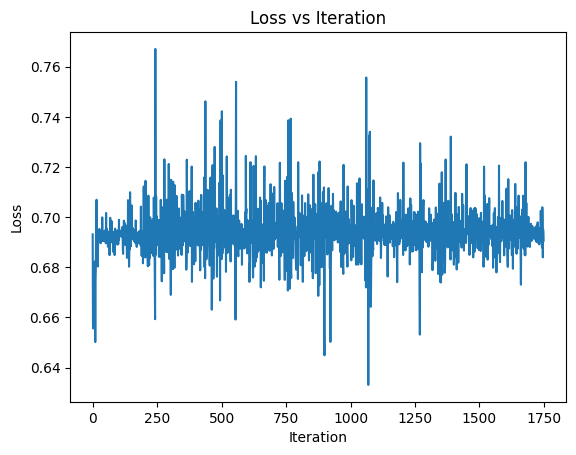

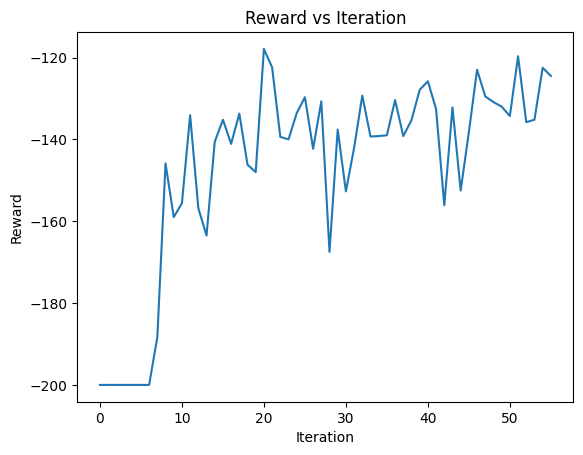

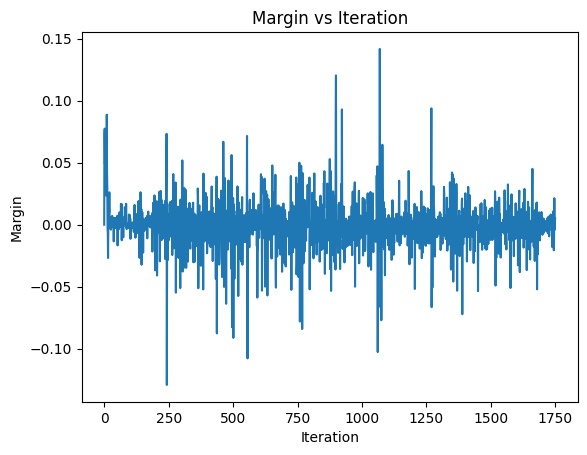

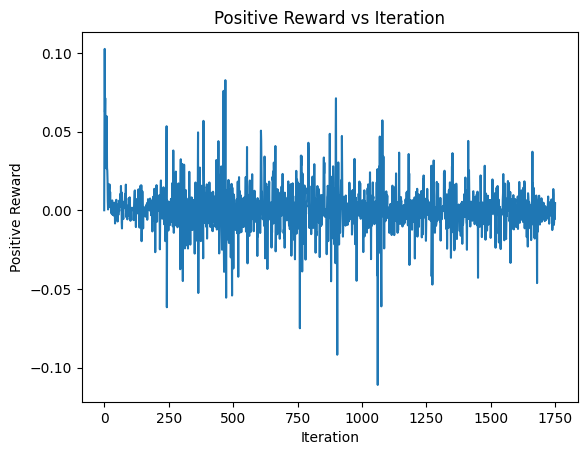

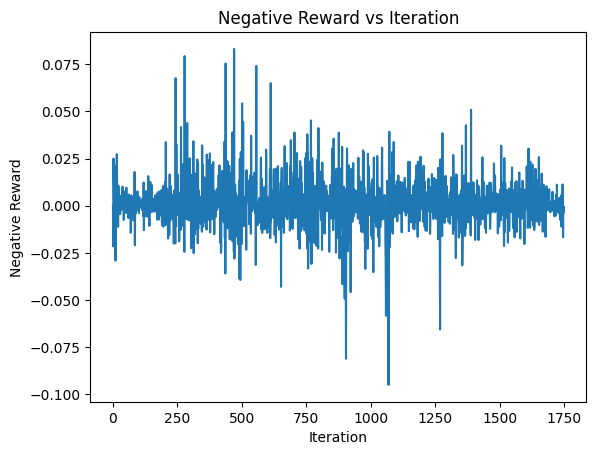

<Figure size 640x480 with 0 Axes>

In [27]:
# save all png to /mnt/nfs/work/albertliu/RL/CartPole-v1/DPO

# draw the loss graph
import matplotlib.pyplot as plt
plt.plot(loss_graph)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss vs Iteration")
plt.show()
plt.savefig("/mnt/nfs/work/albertliu/RL/CartPole-v1/DPO/loss.png")




# draw the reward graph

plt.plot(eval_rewards)
plt.xlabel("Iteration")
plt.ylabel("Reward")
plt.title("Reward vs Iteration")
plt.show()
plt.savefig("/mnt/nfs/work/albertliu/RL/CartPole-v1/DPO/reward.png")

# drqw the margin graph
plt.plot(margin_graph)
plt.xlabel("Iteration")
plt.ylabel("Margin")
plt.title("Margin vs Iteration")
plt.show()
plt.savefig("/mnt/nfs/work/albertliu/RL/CartPole-v1/DPO/margin.png")

# draw the positive reward graph
plt.plot(positive_reward_graph)
plt.xlabel("Iteration")
plt.ylabel("Positive Reward")
plt.title("Positive Reward vs Iteration")
plt.show()
plt.savefig("/mnt/nfs/work/albertliu/RL/CartPole-v1/DPO/positive_reward.png")

# draw the negative reward graph
plt.plot(negative_reward_graph)
plt.xlabel("Iteration")
plt.ylabel("Negative Reward")
plt.title("Negative Reward vs Iteration")
plt.show()

plt.savefig("/mnt/nfs/work/albertliu/RL/CartPole-v1/DPO/negative_reward.png")

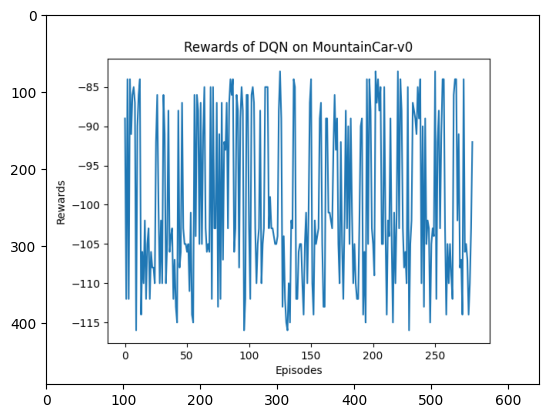

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread("/mnt/nfs/work/albertliu/RL/CartPole-v1/dataset/"+env_id+"_28000_rewards.png")
plt.imshow(img)
plt.show()